This  data set of current-voltage (I-V) curves and associated meteorological data for photovoltaic (PV) modules representing a flat-plate PV for one-year period.
The data measurement location were Eugene PV installed is Oregon(marine west coast climate); These publicly available data are intended to facilitate the validation of existing models for predicting the performance of
PV modules and for the development of new and improved models.
The data include a wide range of irradiance and temperature conditions representing each season.
The data include the following periods:
• Eugene – December 20, 2012, through January 20, 2014

In this notebook we are going to study the aforementoined dataset in order to find periods of **Soiling**. i.e Periods of underperfoming in the aspect of power output. This will be performed with an algorithm for motif search analysis. We will try to perform a constrained motif search through annotating our Time Series in order to guide the algorithm to weight intervals that probable are reffering to Soiling interval.

In [1]:
%matplotlib inline
import pandas as pd
from solarpaper import *
# from modules.inpout import *
# from modules.patterns import *
# from modules.plots import *
# from modules.preprocessing import *
# from modules.similarity import *
# from modules.statistics import *
from ast import literal_eval
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 12,'figure.figsize': [20, 4],'lines.markeredgewidth': 0,
                            'lines.markersize': 2})

We denote the variables we extract from our datasets. We mostly care about:&ensp;

**poa**: The amount of solar irradiance in watts per square meter received on the PV module surface at the time indicated.&ensp;

**mod_temp**: PV module back-surface temperature in degrees Celsius at the time indicated, measured behind center of cell near center of PV module.&ensp;

**Isc**: Short-circuit current of PV module in amperes at the time indicated.&ensp;

**power**: Maximum power of PV module in watts at the time indicated.&ensp;

**humidity**: Relative humidity at the site in percent, nearest 5-second average to the time indicated.&ensp;

**precipitation**: Accumulated daily total precipitation in millimeters at the time indicated.&ensp;

**soiling_derate**: Normalized metric comparing daily performance of a PV module to an identical PV module that is cleaned during daily maintenance.&ensp;

Apart from those we siply create some some important ratios. &ensp;

**Ci_ratio**: $\frac{Isc}{Irrandiance}$. The intuition is the ratio of Irradiance and SC-current would be ideal to be  at 1. When this is not true i.e, is under 1 or less. We suspect a naive problem in our PV.&ensp;

**Pi_ratio**: $\frac{Power}{Irrandiance}$. Simmilirites with the intution of Ci_ratio are present here too. This time  we use Power output over Irradiance. We optimally prefer to absord the most or the free irradiance which is provided daily. Underperformances of theese ratio i.e Under 1, are suspicious behaviors.&ensp;

**Pt_ratio**: $\frac{Power}{Module-Temperature}$. As the previous ones we present another ratio. This time we try to indicate more directly a type for soiling on our PV panels. The intuition for this one comes from the idea that soiling effects are dirt on the panels. This could probably mean that the panel can not absorb more power because of this dirt cover. This behavior becomes suspicious when module temperature is high but the absorbing power is not distributed the same. 

In [2]:
filename = '/data/data1/data-for-validating-models/Data For Validating Models/Eugene/Eugene_mSi0188.csv'

df_meta, df = parse_csv(filename)
df = df.iloc[:, [0, 1, 3, 5, 7,  22, 26, 37]]
df.columns = ['timestamp', 'poa', 'mod_temp',"Isc", 'power',
               'humidity', 'precipitation','soiling_derate']
df = df.set_index('timestamp')
df['ci_ratio']=df.Isc/df.poa
df['pi_ratio']=(df.power/df.poa)
df['pt_ratio']=df.power/df.mod_temp
# start = '10:00'
# end = '16:00'
# df = df.between_time(start, end)
df=df.rolling('7D').mean()
df=df.resample('1D').mean()

temp=df.loc[:,['poa', 'mod_temp', 'power','Isc',
               'humidity', 'precipitation','ci_ratio','pi_ratio', "pt_ratio"]]
scaler=MinMaxScaler()
temp = pd.DataFrame(scaler.fit_transform(temp), columns=temp.columns, index=temp.index)
df=temp.join(df['soiling_derate'])
df = df.dropna()
df.head()

,poa,mod_temp,power,Isc,humidity,precipitation,ci_ratio,pi_ratio,pt_ratio,soiling_derate
timestamp,,,,,,,,,,
2012-12-20,0.000000,0.045766,0.000000,0.000000,0.920207,1.000000,1.000000,0.225281,0.000000,1.0
2012-12-21,0.045610,0.090109,0.042315,0.046193,0.925802,0.641429,0.859053,0.311303,0.019306,1.0
2012-12-22,0.120353,0.133839,0.116340,0.123110,0.869525,0.373953,0.759735,0.380984,0.045815,1.0
2012-12-23,0.141380,0.143950,0.137609,0.145129,0.829343,0.352578,0.744238,0.406379,0.052602,1.0
2012-12-24,0.160055,0.155329,0.156217,0.164921,0.828573,0.340398,0.718426,0.444457,0.059675,1.0


We are taking advantage of the precipitation variable and easily we can distinguish rains that occured in our sets. We simply check all the dates and if the previous from the next have a numerical difference i.e, they are not zero, then a rain occured. Of course with higher the precipitation more liters of water fell on our Panels, so it would be ideal to recognise significant rains which we can from ordinary light rains. This can easily happen user defined from the variable ${presi=0.01}$ as a default price

We found 1 Rains with precipitation over 0.2 
The indication of the start of a Rain is presented with Bold line
The indication of the end of a Rain is presented with Uncontinious line


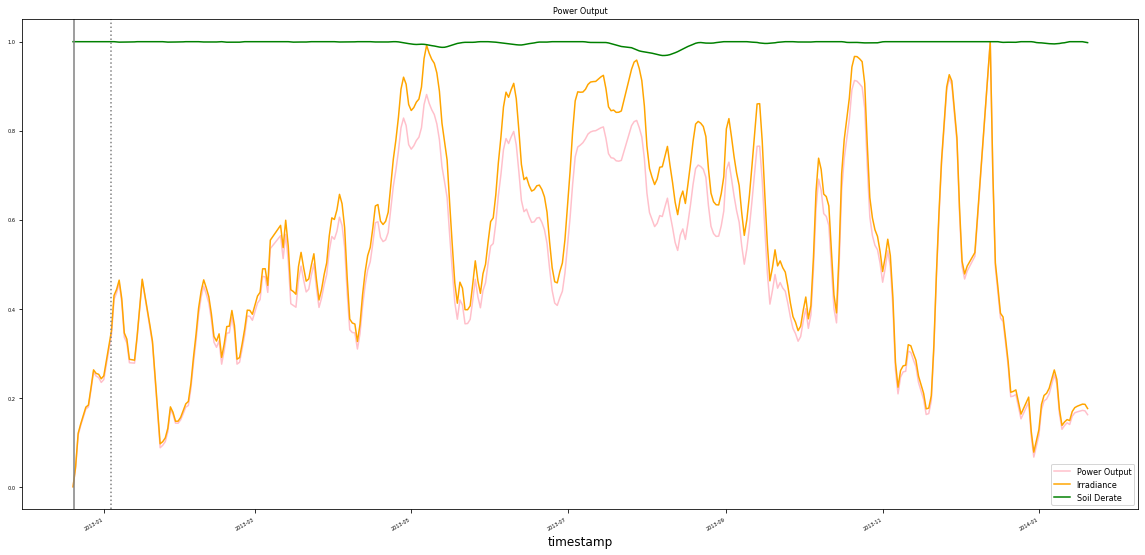

In [3]:
#Find ALL rains #For Eugene
precipitation = pd.concat([pd.Series({'2012-12-20 10:35:00': 0}),df.precipitation])
precipitation.index = pd.to_datetime(precipitation.index)
df_dates = pd.DataFrame(index = precipitation.index)
df_dates["rain_start"] = precipitation[(precipitation.shift(-1) > 0) & (precipitation == 0)] # compare current to next
df_dates["rain_stop"] = precipitation[(precipitation.shift(1) > 0) & (precipitation == 0)] # compare current to prev
dates_rain_start = pd.Series(df_dates.rain_start.index[df_dates.rain_start.notna()])
dates_rain_stop = pd.Series(df_dates.rain_stop.index[df_dates.rain_stop.notna()])

#Filter significant rains with more than 'presi' percipitation
ids = []
presi=0.2
for idx in range(dates_rain_start.size):
    d1 = dates_rain_start[idx]
    d2 = dates_rain_stop[idx]
    if np.max(precipitation.loc[d1:d2]) >= presi:
        ids.append(idx)
dates_rain_start_filtered = dates_rain_start[ids]
dates_rain_stop_filtered = dates_rain_stop[ids]

#df forsignificant rains.
df_rains_output = pd.DataFrame.from_dict({"RainStart": dates_rain_start_filtered, "RainStop": dates_rain_stop_filtered})
df_rains_output=df_rains_output.reset_index(drop='index')
df_rains_output.reset_index(drop='index',inplace=True)

#washing dates for Eugene: 
dates_wash_start = pd.to_datetime(pd.Series(['2013-03-11 00:00:00', '2013-07-10 00:00:00', '2013-08-14 00:00:00', '2013-08-21 00:00:00', '2013-08-26 00:00:00']))
dates_wash_stop = pd.to_datetime(pd.Series(['2013-03-12 00:00:00', '2013-07-11 00:00:00', '2013-08-15 00:00:00', '2013-08-22 00:00:00','2013-08-27 00:00:00']))
                                          
# #df for washing events
df_wash_output = pd.DataFrame.from_dict({"WashStart": dates_wash_start, "WashStop": dates_wash_stop})
df_wash_output=df_wash_output.reset_index(drop='index')
print(f"We found {df_rains_output.shape[0]} Rains with precipitation over {presi} ")
print('The indication of the start of a Rain is presented with Bold line')
print('The indication of the end of a Rain is presented with Uncontinious line')
ax = (df.power).plot(fontsize=5,figsize=(16,6),label='Power Output',color='pink')
ax=df.poa.plot(figsize=(20,10),label='Irradiance',color='orange')
ax=df.soiling_derate.plot(figsize=(20,10),label='Soil Derate',color='green')


for d in df_rains_output.RainStart:
    ax.axvline(x=d, color='grey', linestyle='-')
for d in df_rains_output.RainStop:
    ax.axvline(x=d, color='grey', linestyle=':') 
ax.set_title('Power Output', fontsize=8)
plt.legend(fontsize=8)
plt.show()

### Matrix Profile, Annotation Vectors Dictionary. 

In the next step we create a mandatory **Matrix Profile setting** . We are going to compute some profiles with 10, 15, 20, 25, 30 Days pattern lengths as a Default prices. This is going to be our basis for the motif search and after a constrained motif search and motif cleaning. The constrained motif search is a much more compatible procedure to our Soiling Detection use case.

In [4]:
dates = pd.DataFrame(index=range(len(df)))
dates = dates.set_index(df.index)
dates['power']=df['power']
dates['soil']=df.soiling_derate
dates['preci']=df.precipitation
dates['irradiance']=df.poa
# We transform our dataset into arrays. This helps profile. and later for plotting.
dfdaypower=np.asarray(df['power']).astype(np.float64)
dfdayirr=np.asarray(df['poa']).astype(np.float64)
dfdaypr=np.asarray(df['precipitation']).astype(np.float64)
dfdaysoil=np.asarray(df['soiling_derate']).astype(np.float64)
#Create of a dictionary with the length of days we use for  creation of matrixprofile
days_dict ={
    '10-Days': 10,
    "15-Days": 15,
     "20-Days": 20,
     "25-Days": 25,
     "30-Days": 30}
days_df = pd.DataFrame.from_dict(days_dict, orient='index', columns=['m'])
mps = {}
mot= days_df['m'].values  # window size or length of the patterns we are looking for

#calculate the one-dimensional MP here for Raw Power
for m in mot:
    mps[m] = stump(dfdaypower, m,ignore_trivial=True,normalize=True)
    print(f"Finished for {m}-Days")

Finished for 10-Days
Finished for 15-Days
Finished for 20-Days
Finished for 25-Days
Finished for 30-Days


After the calculation of the profiles some pre-defined **annotation vectors** are computed in order to perform a **guided Motif Search** for our Soilng use case. Correspondingly a user defined vector is possible through our computation procedure. An **annotation vector (AV)** is a time-series of numbers in the range of $[0,1]$ which correspond to how significant a is at that index (In our case time interval). More specifically, a 1 in the in the AV means that any motif starting at that time interval is heavily important and be conserved whereas a 0 means that the computed motif can and will be discarded or ignored for our scenario or our use case. Of course, any values between 1 and 0 is possible to exist and the definition of those values could simply mean that as more near the former we consider those motifs to hold more information that the motifs found in the latter. As a result, annotation vectors allow users to ignore insignificant patterns in a time-series. This procedure takes place in order to fix/ correct the computed matrix profiles so to use the new one for our future computations. Our tool supports all of the procedure even when the user does not wish this extra step of annotating the time-series.&ensp;

We are presenting the notation of the transformation of the computed matrix profile when a user inputs an annotation vector: $\begin{align*}CMP[i] &= MP[i] + (1 - AV[i]) \times max(MP)\end{align*}$ &ensp;

Where $CMP$ is the corrected matrix profile &ensp;

$MP$ is the matrix profile &ensp;

$AV$ is the annotation vector

In [5]:
#Create the sets we will later use
df['pi_ratio_av'] = np.inf
df['pt_ratio_av'] = np.inf
df['ci_ratio_av'] = np.inf
df['mmperf_av']   = np.inf

corrected_matrix_profile_ciratio = {}
corrected_matrix_profile_piratio = {}
corrected_matrix_profile_ptratio = {}
corrected_matrix_profile_mmperf  = {}

ciratio = {}
piratio = {}
ptratio = {}
mmperf  = {}

for i in range(0,df.shape[0]):
    #perform every itter someone pleases to create the vectors
    df['pi_ratio_av'] = (df['pi_ratio'].max()-df['pi_ratio'])/(df['pi_ratio'].max()-df['pi_ratio'].min())
    df['pt_ratio_av'] = (df['pt_ratio'].max()-df['pt_ratio'])/(df['pt_ratio'].max()-df['pt_ratio'].min())
    df['ci_ratio_av'] = (1-df.ci_ratio) #(df['perf'].max()-df['perf'])/(df['perf'].max()-df['perf'].min())
    df['mmperf_av']   = df.power/df.Isc #1-(df['perf_av'].max()-df['perf_av'])/(df['perf_av'].max()-df['perf_av'].min())
df['mmperf_av'] = 1/df.mmperf_av
df['mmperf_av'] = (df['mmperf_av'] - np.min(df['mmperf_av'])) / (np.max(df['mmperf_av']) - np.min(df['mmperf_av']))
for m in mot:
    temp0 = pd.Series(df['pi_ratio_av'])
    temp1 = pd.Series(df['pt_ratio_av'])
    temp2 = pd.Series(df['ci_ratio_av'])
    temp3 = pd.Series(df['mmperf_av'])
#We always need to make sure that our new columns are in the same shape 
#with the profile so we start from the index m and so on
    temp0 = np.array(temp0[m - 1:])
    temp1 = np.array(temp1[m - 1:])
    temp2 = np.array(temp2[m - 1:])
    temp3 = np.array(temp3[m - 1:])
                                                   
    piratio[m] = temp0.astype(np.uint8)
    ptratio[m] = temp1.astype(np.uint8)
    ciratio[m] = temp2.astype(np.uint8)
    mmperf[m]  = temp3.astype(np.uint8)
                                                
                                    
# Calculate the CMP                                            
for m in days_df['m'].values:
    corrected_matrix_profile_piratio[m] = get_corrected_matrix_profile(mps[m], piratio[m])
    corrected_matrix_profile_ptratio[m] = get_corrected_matrix_profile(mps[m], ptratio[m])
    corrected_matrix_profile_ciratio[m] = get_corrected_matrix_profile(mps[m],ciratio[m]) 
    corrected_matrix_profile_mmperf[m]  = get_corrected_matrix_profile(mps[m],mmperf[m])                               

In the previous steps we have created some annotation vectors. This occured in order to impliment a **constrained Motif search**. This specific search tries to allign with with different events that occured in a PV panel and more specifically we want to use those vectors for our Soiling Use case. The idea is to create a pseudo timeseries in order to annotate (add weight) to some dates of our original timeseries. For example, given a ground truth problem such as soiling derate we employ those vectors to weight more in the regions that soiling derate is significant for our problem. If we dont have the ground truth it is still just fine because we did not use it for our vectors. So our vectors are agnostic to the truth but still they behave in a good way. In the next steps  we are going to have a visual overview of the constrained motifs found. We ranked those motifs by considering  how many times a motif instance passed over a raining or a washing event. Right after we created a dataframe with some significant statistics that occured from the the neighbors of each motif type for each pattern length. In the next lines we will give an approach to the user of those AVs.

#### PI ratio Annotation
Description of the AV &ensp;

We have already produced a **PI ratio** from **Power/Irradiance**. The idea is that when we see a reduction in this ratio its is probable that an event is taking place. The reader can check again Cell [1] for reminding. We have already annotated this PseudoTimeseries with a custom scaler in order to add weight in intervals which the soiling is taking place.
$$ {\frac{\max{PI}_{ratio}-PI_{ratio}}{\max{PI}_{ratio}-\min{PI}_{ratio}}} $$


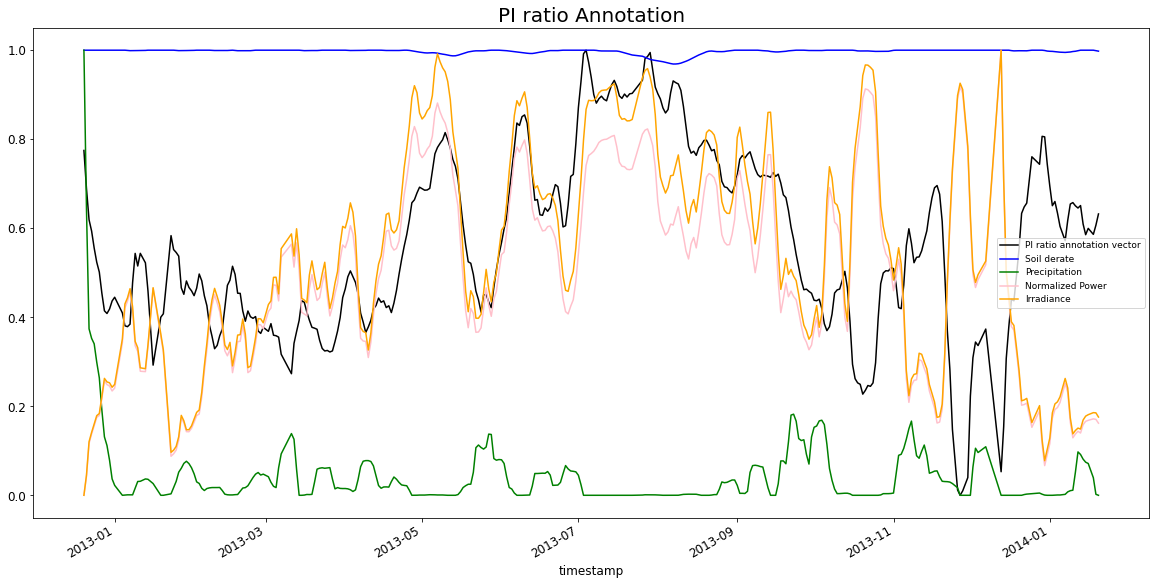

In [6]:
ax = (df['pi_ratio_av']).plot(figsize=(20,10),label='PI ratio annotation vector',color='black')
ax=df.soiling_derate.plot(figsize=(20,10),label='Soil derate',color='blue')
ax=df.precipitation.plot(figsize=(20,10),label='Precipitation',color='green')
ax=(df.power).plot(figsize=(20,10),label='Normalized Power',color='pink')
ax=df.poa.plot(figsize=(20,10),label='Irradiance',color='orange')

# for d in df_rains_output.RainStart:
#     ax.axvline(x=d, color='red', linestyle='-')
# for d in df_rains_output.RainStop:
#     ax.axvline(x=d, color='brown', linestyle=':') 
# ax.set_title('PI ratio Annotation', fontsize=20)
ax.set_title('PI ratio Annotation', fontsize=20)


plt.legend(fontsize=9)
#plt.savefig(f'RainWash.jpg')
plt.show()

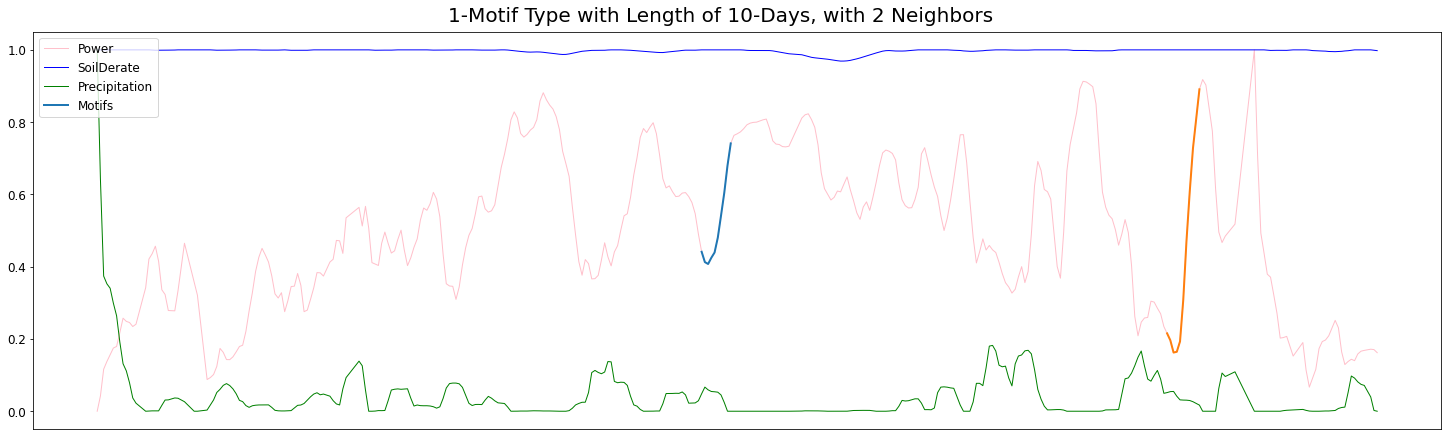

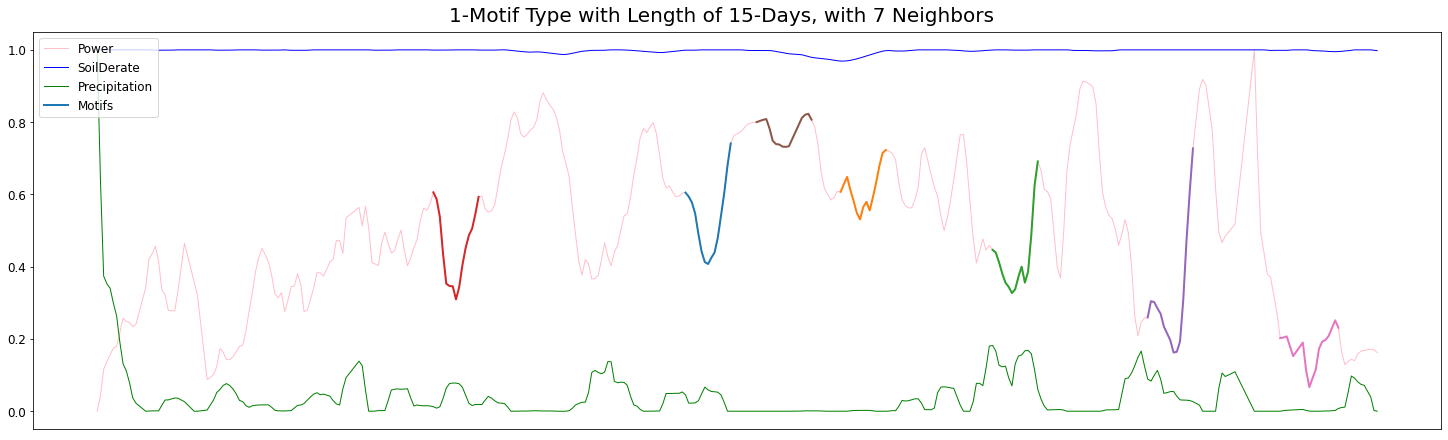

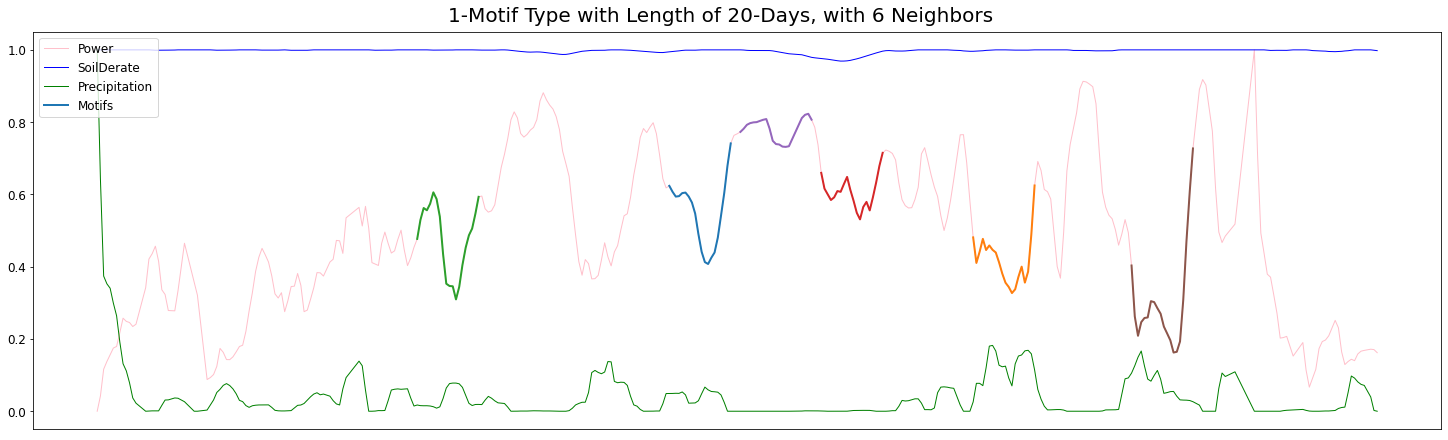

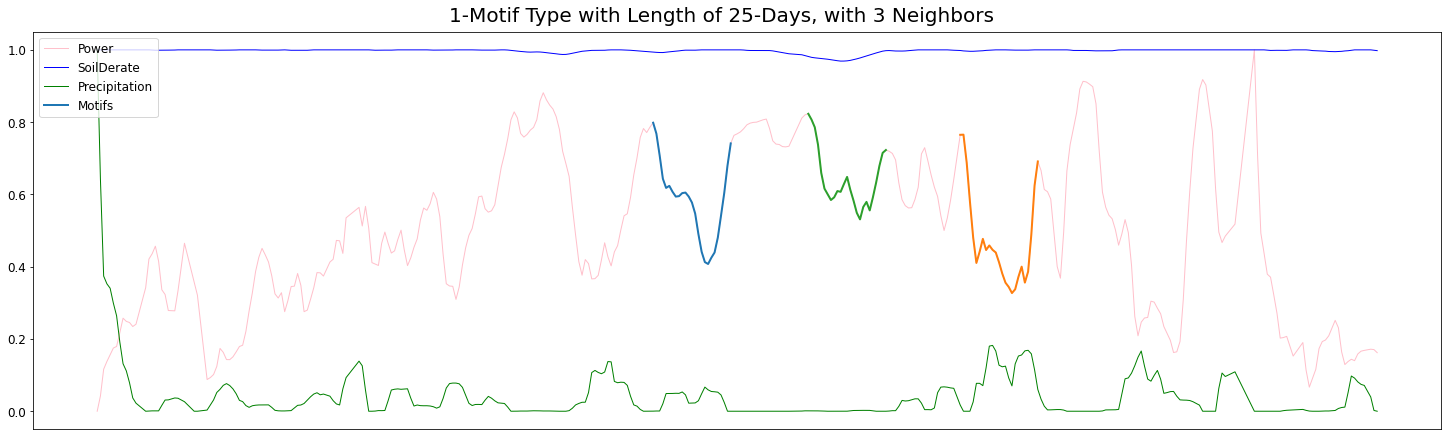

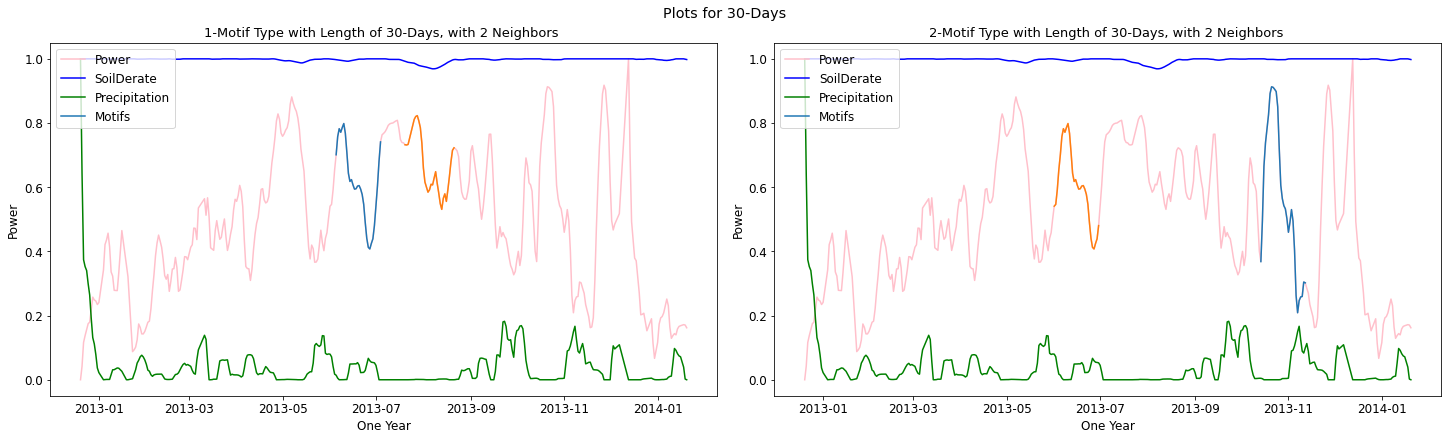

,Pattern Lenght in Days,Motif type,Motif Instances passing from Wash/Rain,Motif Neighbors,Soil Derate Before,Soil Derate After,Slope at motif %,Slope Before Motif %,Slope ratio,Mean Power Before Motif,Gain of Power %,Mean Power of Neighbors,Mean Precititation of Neighbors,Precipitation Percentage %
3,25,1,0,3,0.989754,0.996556,-0.636590,0.257568,-0.404606,0.674583,2.195378,0.689725,0.010512,-19.599072
4,30,1,0,2,0.997766,0.993706,-0.754230,0.285801,-0.378931,0.585889,13.092612,0.674154,0.017079,-142.938239
5,30,2,0,2,0.997448,0.996285,-1.437339,0.223107,-0.155222,0.593701,2.700862,0.610181,0.017830,-41.661193


In [7]:
miclean0={}
mdclean0={}
Ranking0={}
wholedict0={}
miclean0,mdclean0= clean_motifs(corrected=corrected_matrix_profile_piratio,mot=mot,dailypower=dfdaypower,max_motifs=25,min_nei=1,max_di=None,cut=None,max_matc=200)
Ranking0,wholedict0= Ranker(df,mot,miclean0,mdclean0,df_rains_output,df_wash_output)
motif_plot(df,mot,miclean0,dfdaypower,wholedict0,Ranking0,show_best=False)
summary_motifs(mot,wholedict0,Ranking0,show_best=True)

#### PT ratio Annotation
Description of the AV &ensp;

We have already produced a **PT ratio** from **Power/module_Temperature**. The idea is that when we see a reduction in this ratio its is probable that an event is taking place. Check Cell [1] for reminding. We have already annotated this PseudoTimeseries with a custom scaler in order to add weight in intervals which the soiling is taking place.
$$ {\frac{\max{PT_{ratio}}-PT_{ratio}}{\max{PT_{ratio}}-\min{PT_{ratio}}}} $$

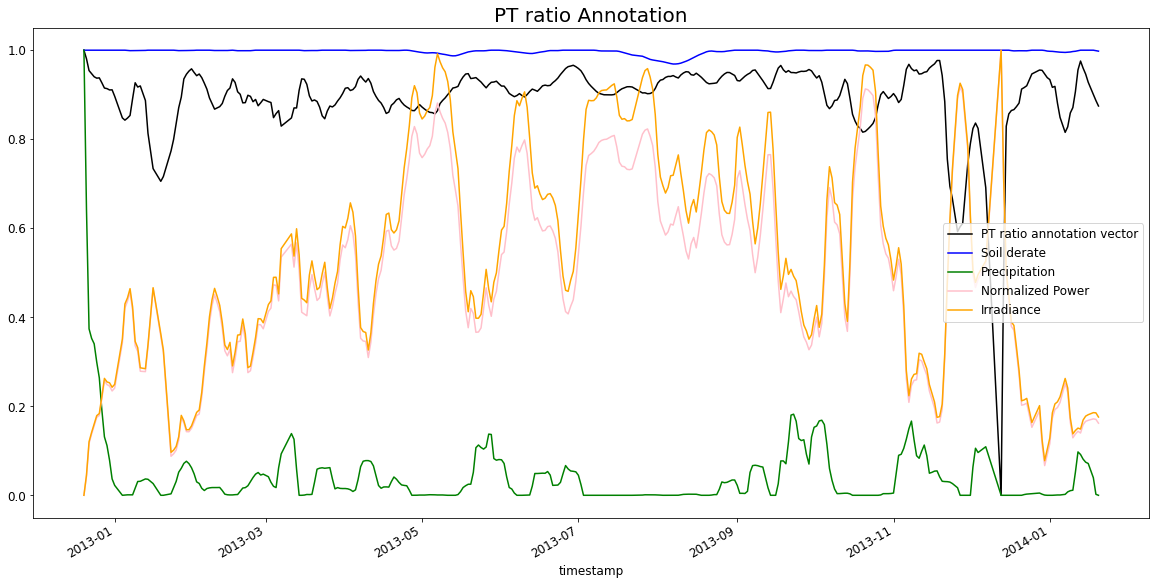

In [8]:
ax = (df['pt_ratio_av']).plot(figsize=(20,10),label='PT ratio annotation vector',color='black')
ax=df.soiling_derate.plot(figsize=(20,10),label='Soil derate',color='blue')
ax=df.precipitation.plot(figsize=(20,10),label='Precipitation',color='green')
ax=df.power.plot(figsize=(20,10),label='Normalized Power',color='pink')
ax=df.poa.plot(figsize=(20,10),label='Irradiance',color='orange')


# for d in df_rains_output.RainStart:
#     ax.axvline(x=d, color='red', linestyle='-')
# for d in df_rains_output.RainStop:

#     ax.axvline(x=d, color='brown', linestyle=':') 
ax.set_title('PT ratio Annotation', fontsize=20)

plt.legend()
#plt.savefig(f'RainWash.jpg')
plt.show()

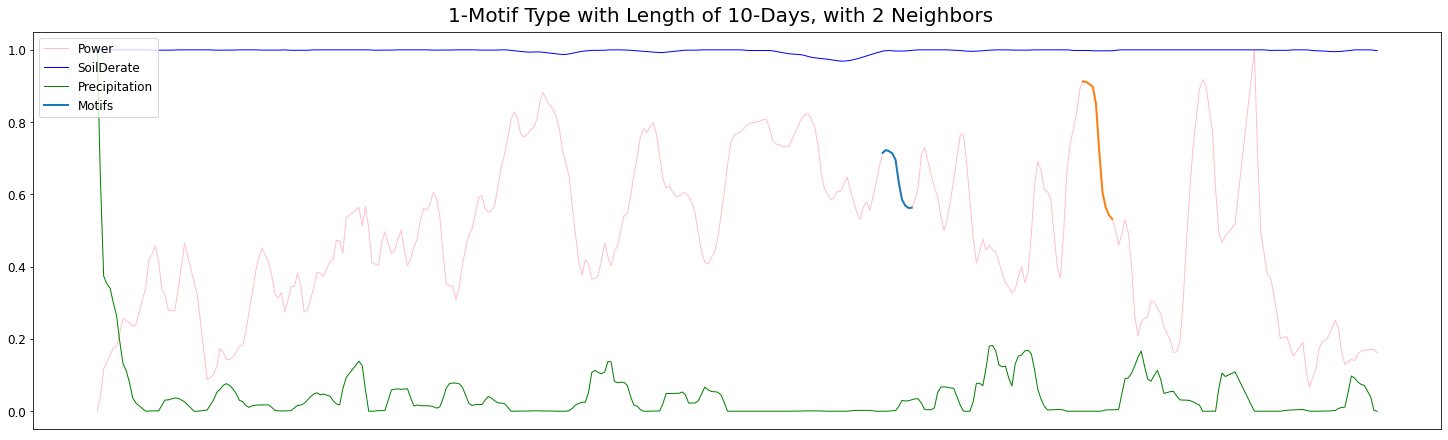

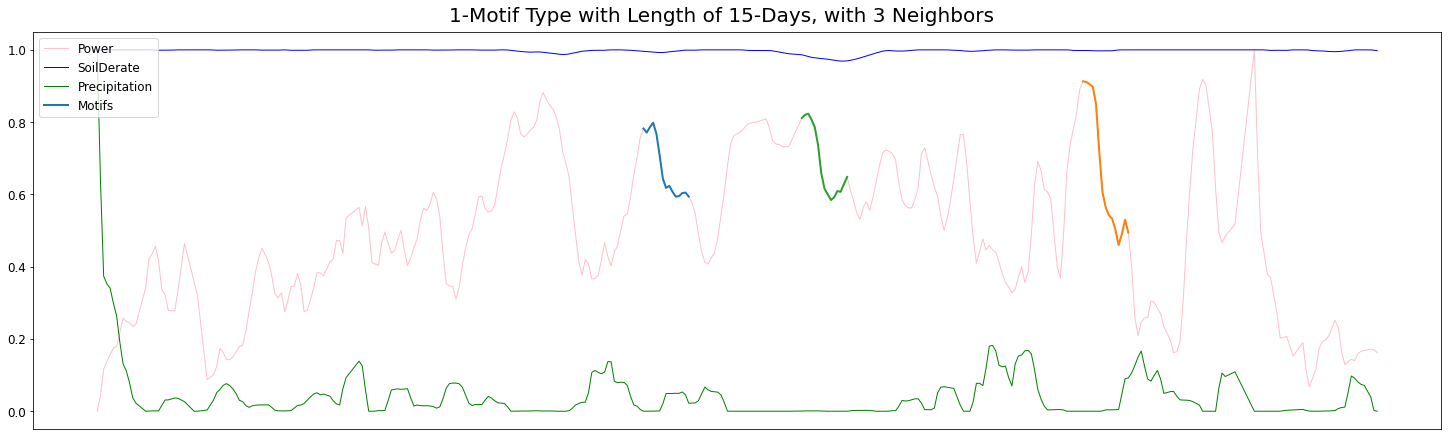

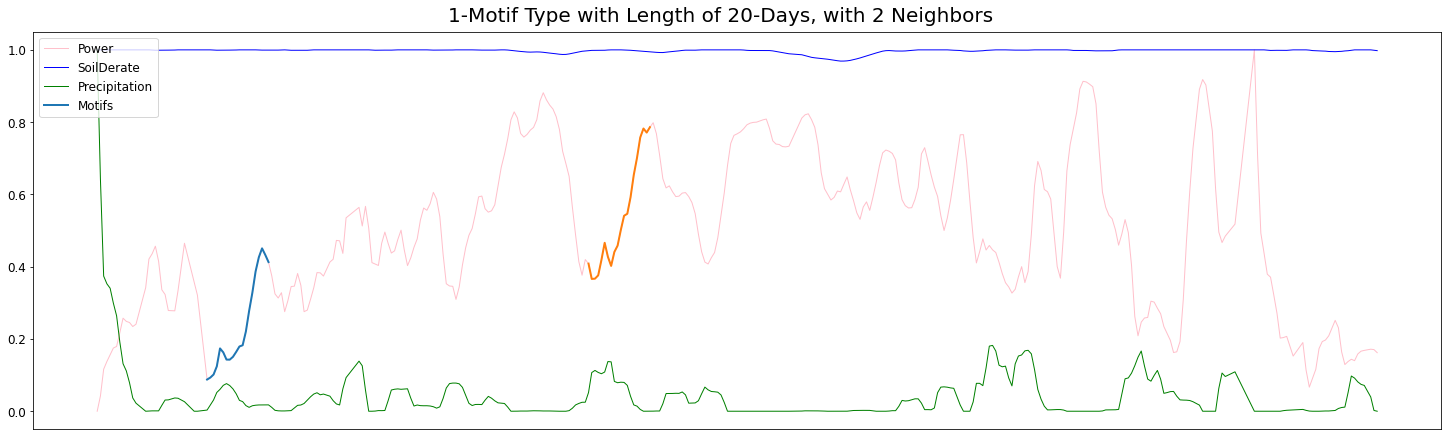

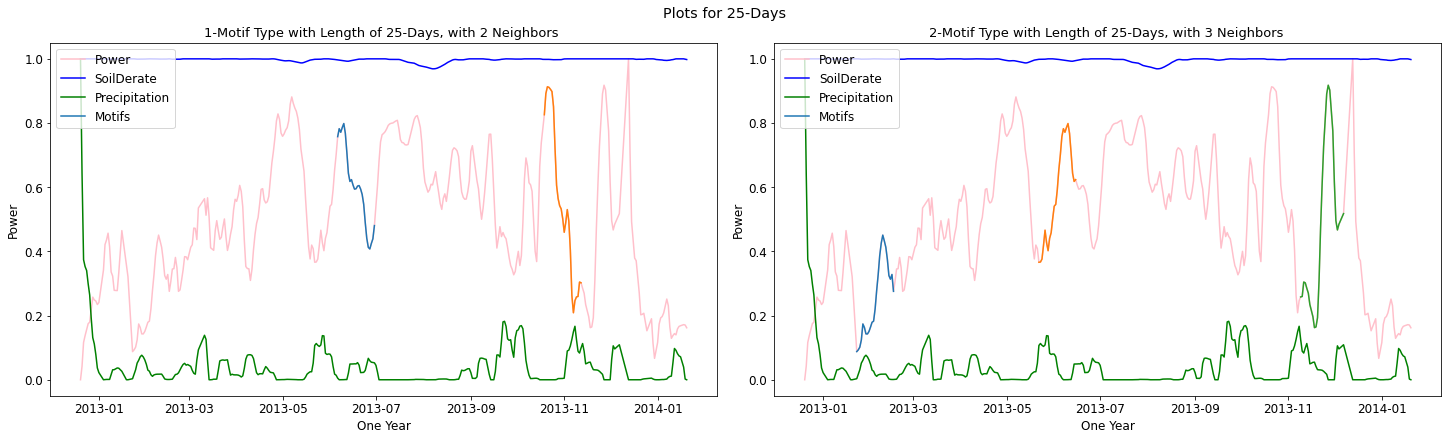

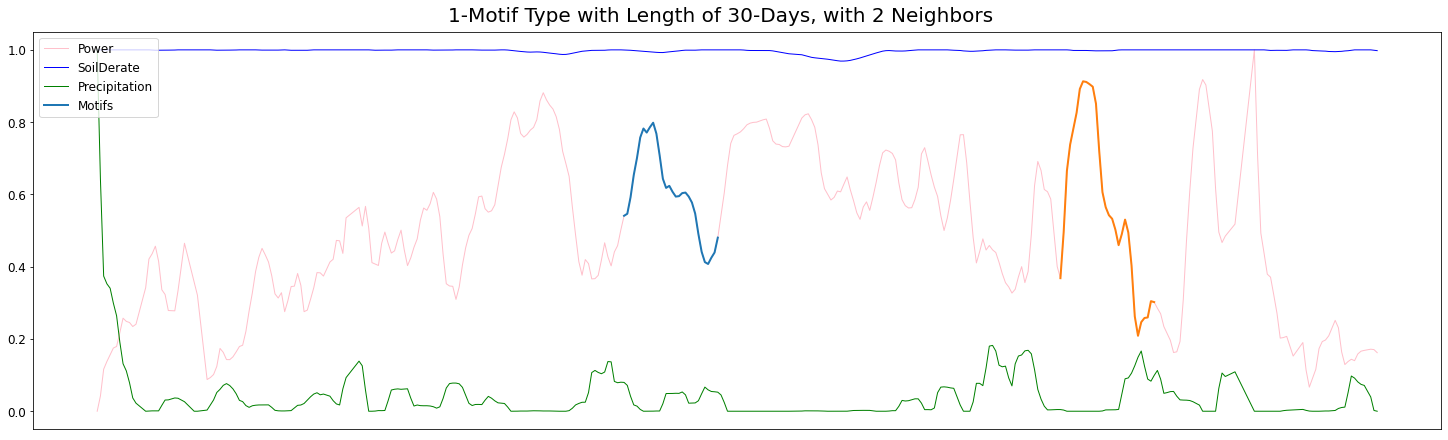

,Pattern Lenght in Days,Motif type,Motif Instances passing from Wash/Rain,Motif Neighbors,Soil Derate Before,Soil Derate After,Slope at motif %,Slope Before Motif %,Slope ratio,Mean Power Before Motif,Gain of Power %,Mean Power of Neighbors,Mean Precititation of Neighbors,Precipitation Percentage %
0,10,1,0,2,0.986014,0.999876,-3.758402,0.177285,-0.047170,0.560997,-11.024597,0.505291,0.060461,4.174484
1,15,1,0,3,0.997113,0.995686,-2.430998,0.234139,-0.096314,0.526358,-9.971555,0.478631,0.042145,-44.903215
3,25,1,0,2,0.997428,0.997950,-2.402972,0.217092,-0.090343,0.660943,-5.046140,0.629193,0.021307,-29.846488
5,30,1,0,2,0.997448,0.996285,-1.437339,0.223107,-0.155222,0.593701,2.700862,0.610181,0.017830,-41.661193


In [9]:
miclean1={}
mdclean1={}
Ranking1={}
wholedict1={}
miclean1,mdclean1= clean_motifs(corrected=corrected_matrix_profile_ptratio,mot=mot,dailypower=dfdaypower,max_motifs=25,min_nei=1,max_di=None,cut=None,max_matc=200)
Ranking1,wholedict1= Ranker(df,mot,miclean1,mdclean1,df_rains_output,df_wash_output)
motif_plot(df,mot,miclean1,dfdaypower,wholedict1,Ranking1,show_best=False)
summary_motifs(mot,wholedict1,Ranking1,show_best=True)

#### CI ratio Annotation

Description of the AV &ensp;

We have already produced a **CI ratio** from **Isc/Irradiance**. The idea is already explained in the [1] Cell. We have already annotated this PseudoTimeseries with a custom scaler in order to add weight in intervals which the soiling is taking place.
$$ {1-CI _{ratio}} $$

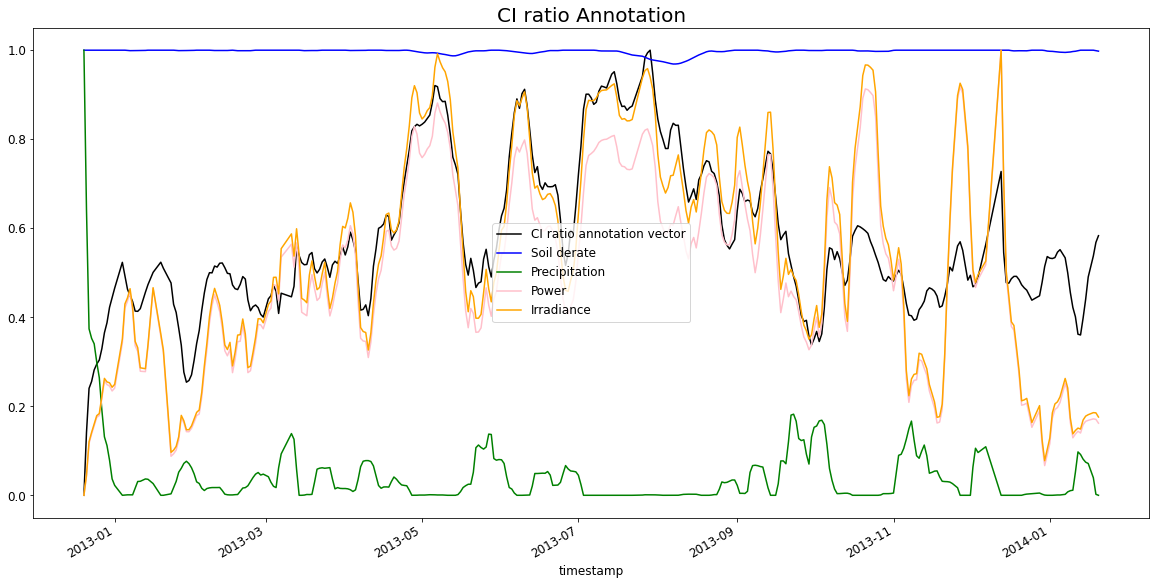

In [10]:
ax = (df['ci_ratio_av']).plot(figsize=(20,10),label='CI ratio annotation vector',color='black')
ax=df.soiling_derate.plot(figsize=(20,10),label='Soil derate',color='blue')
ax=df.precipitation.plot(figsize=(20,10),label='Precipitation',color='green')
ax=df.power.plot(figsize=(20,10),label='Power',color='pink')
ax=df.poa.plot(figsize=(20,10),label='Irradiance',color='orange')


# for d in df_rains_output.RainStart:
#     ax.axvline(x=d, color='red', linestyle='-')
# for d in df_rains_output.RainStop:
#     ax.axvline(x=d, color='brown', linestyle=':') 
ax.set_title('CI ratio Annotation', fontsize=20)

plt.legend()
#plt.savefig(f'RainWash.jpg')
plt.show()

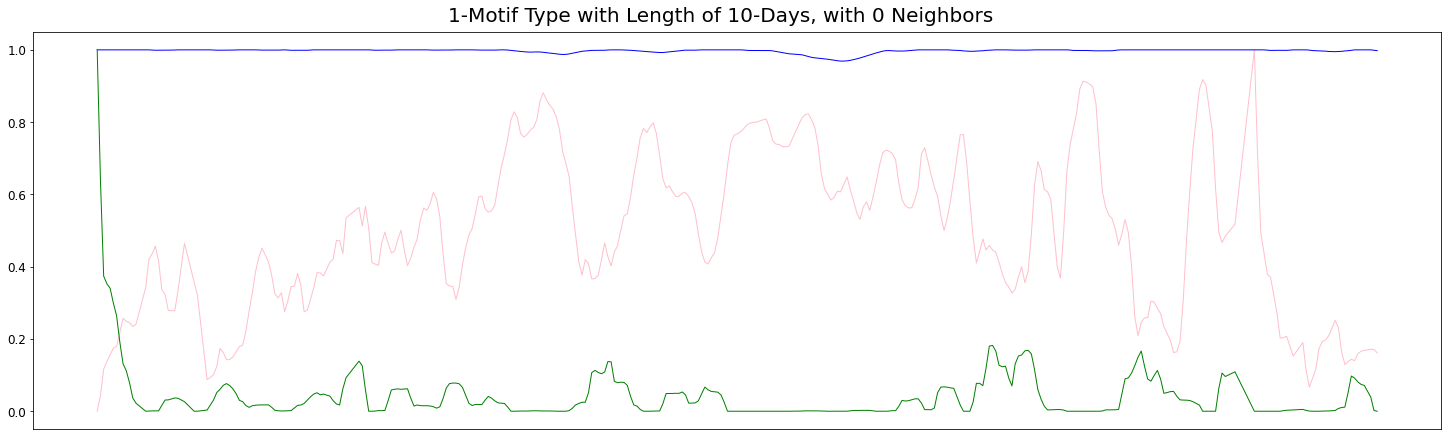

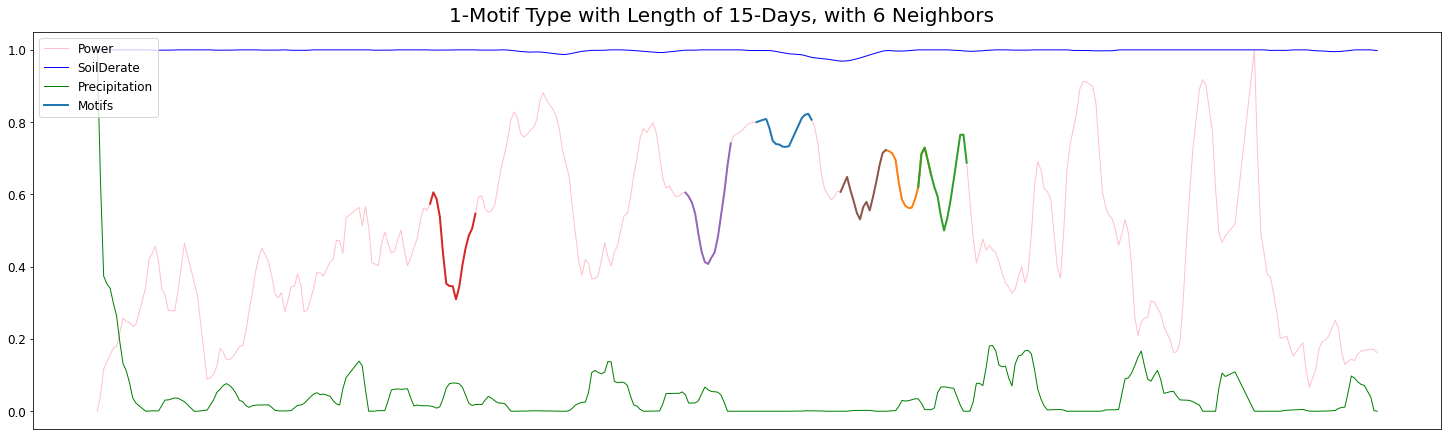

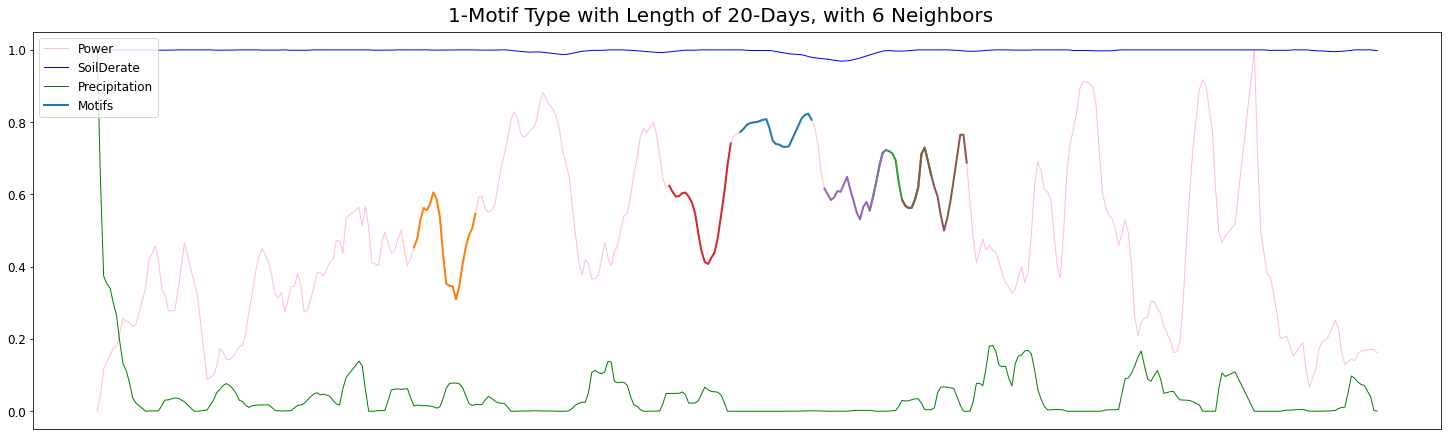

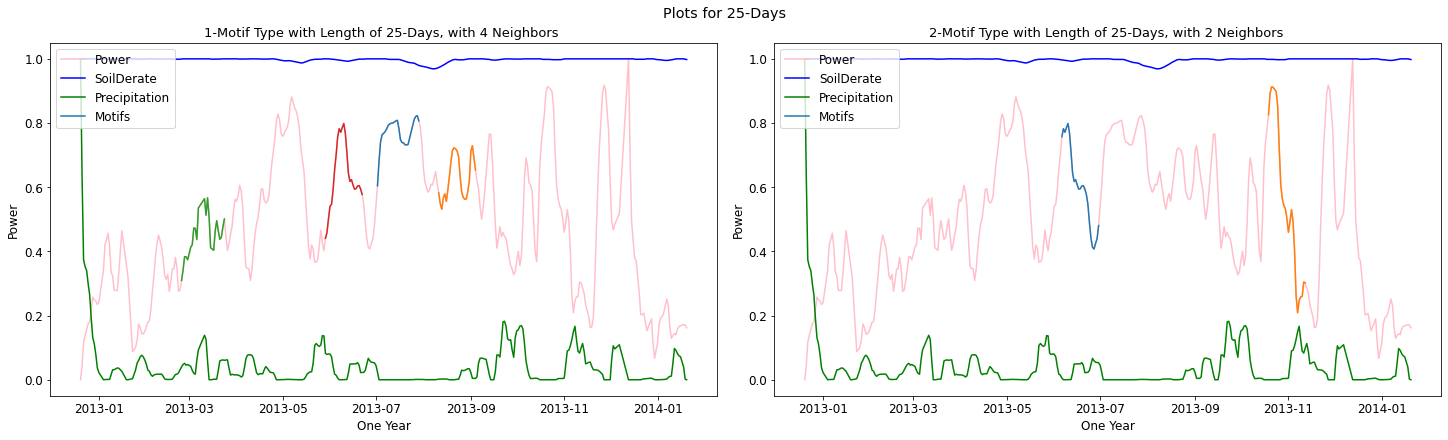

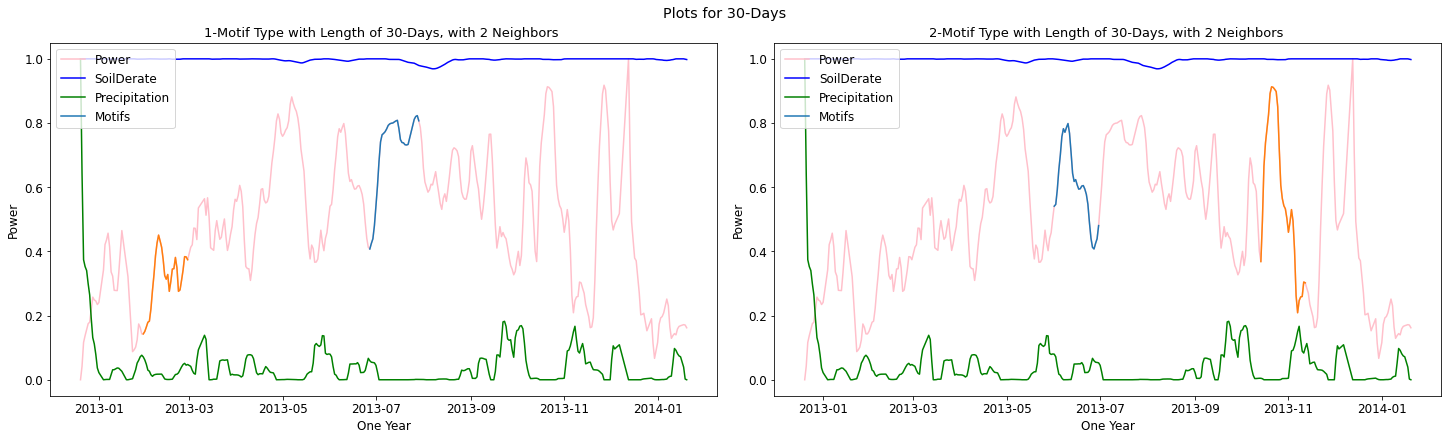

,Pattern Lenght in Days,Motif type,Motif Instances passing from Wash/Rain,Motif Neighbors,Soil Derate Before,Soil Derate After,Slope at motif %,Slope Before Motif %,Slope ratio,Mean Power Before Motif,Gain of Power %,Mean Power of Neighbors,Mean Precititation of Neighbors,Precipitation Percentage %
3,25,2,0,2,0.997428,0.997950,-2.402972,0.217092,-0.090343,0.660943,-5.046140,0.629193,0.021307,-29.846488
5,30,2,0,2,0.997448,0.996285,-1.437339,0.223107,-0.155222,0.593701,2.700862,0.610181,0.017830,-41.661193


In [11]:
miclean={}
mdclean={}
Ranking={}
wholedict={}

miclean,mdclean= clean_motifs(corrected=corrected_matrix_profile_ciratio,mot=mot,dailypower=dfdaypower,max_motifs=25,min_nei=1,max_di=None,cut=None,max_matc=200)
Ranking,wholedict= Ranker(df,mot,miclean,mdclean,df_rains_output,df_wash_output)
motif_plot(df,mot,miclean,dfdaypower,wholedict,Ranking,show_best=False)
summary_motifs(mot,wholedict,Ranking,show_best=True)

#### Performace Index

Description of the AV &ensp;

We have created in Cell [5] already a ratio of $PerfIndex=\frac{Power}{Isc}$. This is called Performance Index and is a solid measure. The idea is that when we diverge from 1 it is mostly propable that an event to take place. This ratio goes to $[0,1]$, because we care more about the points which are near to zero we are going to use as annotation vector the $PerfIndex = \frac{1}{PerfIndex}$ and right after to a typical scaler.
$$PerfIndex= \frac{PerfIndex-\min{PerfIndex}}{\max{PerfIndex}-\min{PerfIndex}}$$  

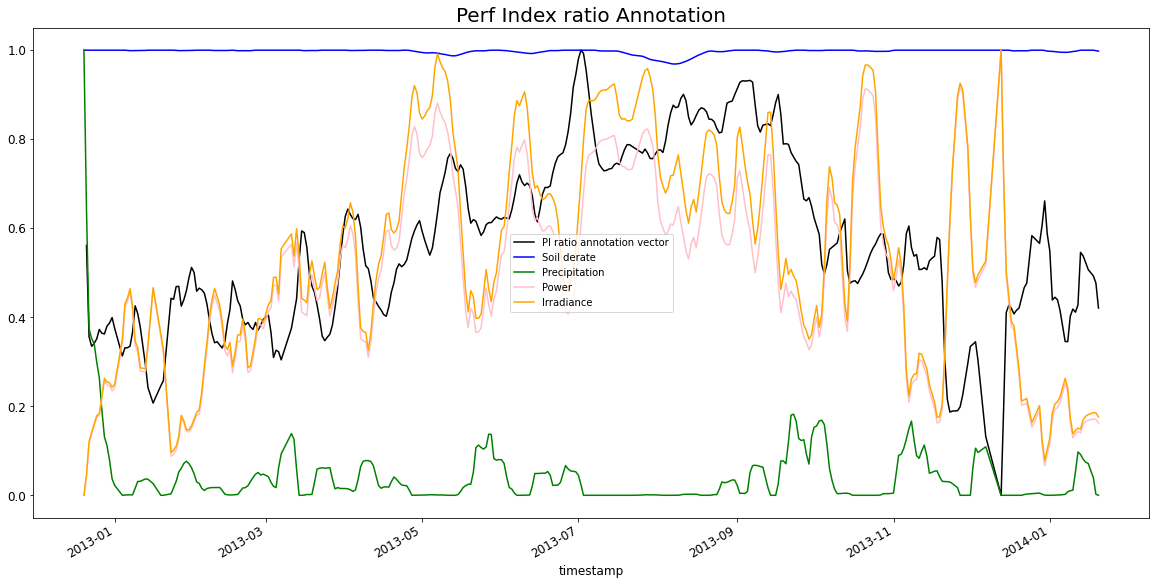

In [12]:
ax = (df['mmperf_av']).plot(figsize=(20,10),label='PI ratio annotation vector',color='black')
ax=df.soiling_derate.plot(figsize=(20,10),label='Soil derate',color='blue')
ax=df.precipitation.plot(figsize=(20,10),label='Precipitation',color='green')
ax=(df.power).plot(figsize=(20,10),label='Power',color='pink')
ax=df.poa.plot(figsize=(20,10),label='Irradiance',color='orange')


# for d in df_rains_output.RainStart:
#     ax.axvline(x=d, color='red', linestyle='-')
# for d in df_rains_output.RainStop:
#     ax.axvline(x=d, color='brown', linestyle=':') 
# ax.set_title('PI ratio Annotation', fontsize=20)
ax.set_title('Perf Index ratio Annotation', fontsize=20)


plt.legend(fontsize=10)
#plt.savefig(f'RainWash.jpg')
plt.show()

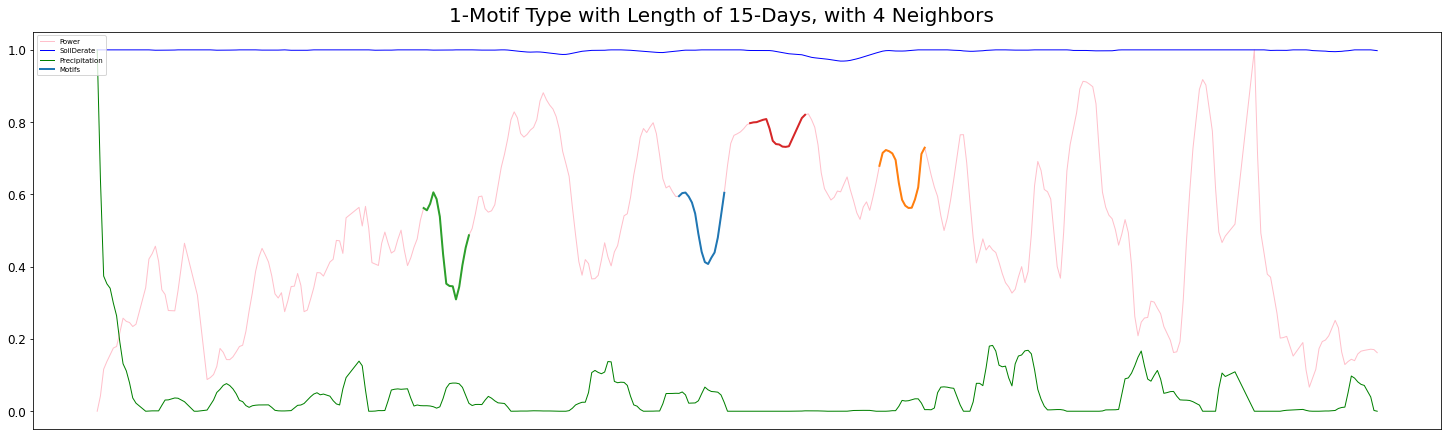

,Pattern Lenght in Days,Motif type,Motif Instances passing from Wash/Rain,Motif Neighbors,Soil Derate Before,Soil Derate After,Slope at motif %,Slope Before Motif %,Slope ratio,Mean Power Before Motif,Gain of Power %,Mean Power of Neighbors,Mean Precititation of Neighbors,Precipitation Percentage %
1,15,1,0,4,0.994961,0.992618,-0.803576,0.287886,-0.358256,0.562801,16.163554,0.671308,0.013557,-214.377477


In [14]:
miclean={}
mdclean={}
Ranking={}
wholedict={}

miclean,mdclean= clean_motifs(corrected=corrected_matrix_profile_mmperf,mot=mot,dailypower=dfdaypower,max_motifs=20,min_nei=3,max_di=None,cut=None,max_matc=200)
Ranking,wholedict= Ranker(df,mot,miclean,mdclean,df_rains_output,df_wash_output)
motif_plot(df,mot,miclean,dfdaypower,wholedict,Ranking,show_best=True)
summary_motifs(mot,wholedict,Ranking,show_best=True)